In [1]:
import os
os.chdir("/Users/jacksonwalters/Documents/GitHub/enefit-kaggle/predict-energy-behavior-of-prosumers/")
!ls

client.csv                            gas_prices.csv
county_id_to_name_map.json            historical_weather.csv
electricity_prices.csv                public_timeseries_testing_util.py
enefit                                train.csv
example_test_files                    weather_station_to_county_mapping.csv
forecast_weather.csv


In [2]:
import numpy as np
import pandas as pd

In [32]:
#load the training data, dropping NaN's
train = pd.read_csv("train.csv").dropna()

In [4]:
#helper function to convert datetime strings to integers representing a time year-month-day hour-min-sec
from datetime import datetime
def datestr_to_int(datetime_str,date_format):
    return datetime.strptime(datetime_str, date_format).timestamp()

In [33]:
train['datetime'] = train['datetime'].apply(lambda x: datestr_to_int(x,'%Y-%m-%d %H:%M:%S'))

In [29]:
forecast_weather = pd.read_csv("forecast_weather.csv")

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [9]:
weather_station_to_county_mapping = pd.read_csv("weather_station_to_county_mapping.csv")

In [8]:
historical_weather = pd.read_csv("historical_weather.csv")

In [41]:
gas_prices = pd.read_csv("gas_prices.csv")

In [11]:
electricity_prices = pd.read_csv("electricity_prices.csv")

In [34]:
import matplotlib.pyplot as plt

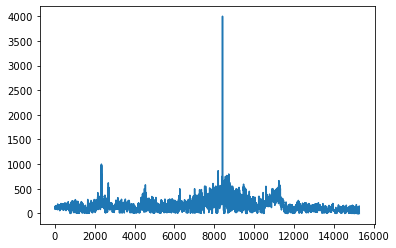

In [13]:
plt.plot(electricity_prices["euros_per_mwh"])

In [57]:
train

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,1.630469e+09,0,0,0
1,0,0,1,96.590,1,1.630469e+09,0,1,0
2,0,0,2,0.000,0,1.630469e+09,0,2,1
3,0,0,2,17.314,1,1.630469e+09,0,3,1
4,0,0,3,2.904,0,1.630469e+09,0,4,2
...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,1.685588e+09,637,2018347,64
2018348,15,1,1,0.000,0,1.685588e+09,637,2018348,59
2018349,15,1,1,28.404,1,1.685588e+09,637,2018349,59
2018350,15,1,3,0.000,0,1.685588e+09,637,2018350,60


In [42]:
#convert date strings to ints
gas_prices['forecast_date'] = gas_prices['forecast_date'].apply(lambda x: datestr_to_int(x,'%Y-%m-%d'))
gas_prices['origin_date'] = gas_prices['origin_date'].apply(lambda x: datestr_to_int(x,'%Y-%m-%d'))

In [16]:
electricity_prices['forecast_date'] = electricity_prices['forecast_date'].apply(lambda x: datestr_to_int(x,'%Y-%m-%d %H:%M:%S'))
electricity_prices['origin_date'] = electricity_prices['origin_date'].apply(lambda x: datestr_to_int(x,'%Y-%m-%d %H:%M:%S'))

In [47]:
electricity_prices

,forecast_date,euros_per_mwh,origin_date,data_block_id
0,1.630469e+09,92.51,1.630382e+09,1
1,1.630472e+09,88.90,1.630386e+09,1
2,1.630476e+09,87.35,1.630390e+09,1
3,1.630480e+09,86.88,1.630393e+09,1
4,1.630483e+09,88.43,1.630397e+09,1
...,...,...,...,...
15281,1.685488e+09,82.10,1.685401e+09,637
15282,1.685491e+09,150.85,1.685405e+09,637
15283,1.685495e+09,82.10,1.685408e+09,637
15284,1.685498e+09,82.09,1.685412e+09,637


In [56]:
gas_prices

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,1.630469e+09,45.23,46.32,1.630382e+09,1
1,1.630555e+09,45.62,46.29,1.630469e+09,2
2,1.630642e+09,45.85,46.40,1.630555e+09,3
3,1.630728e+09,46.30,46.80,1.630642e+09,4
4,1.630814e+09,46.30,46.58,1.630728e+09,5
...,...,...,...,...,...
632,1.685074e+09,29.10,34.10,1.684987e+09,633
633,1.685160e+09,28.30,34.10,1.685074e+09,634
634,1.685246e+09,28.10,34.10,1.685160e+09,635
635,1.685333e+09,28.16,36.98,1.685246e+09,636


In [38]:
#merge train and gas_prices via left join on data_block_id
#this leaves all rows of train, but matches 
df = train.merge(electricity_prices, on='data_block_id', how='left')

In [62]:
df = pd.merge(train, gas_prices, left_on='datetime', right_on='forecast_date', how='left')

In [20]:
#drop NaN rows
df = df.dropna()

In [66]:
#drop the target column to get the training data
X = df.drop("target", axis=1)

In [67]:
#set the target variable
y = df['target']

In [68]:
#verify there are no NaN's
np.any(np.isnan(y))

False

In [24]:
# load the modeling modules from sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.metrics import mean_absolute_error

In [69]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [70]:
#create a multivariable linear regression
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(X, y)

LinearRegression()

In [71]:
#predict on the test data
lin_pred = regr.predict(X_test)

In [72]:
mean_absolute_error(lin_pred,y_test)

285.390094028199

In [73]:
#train the random forest regressor
rf = RandomForestRegressor(n_estimators=10)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10)

In [74]:
#predict the target values using the random forest regressor
rf_pred = rf.predict(X_test)

In [76]:
#mean absolute error for random regressor
mean_absolute_error(y_test,rf_pred)

19.830457300226268